In [1]:

import os
import sys
import pandas as pd
import numpy as np
import warnings 

In [2]:
# Suppressing warning messages

warnings.filterwarnings('ignore')

In [3]:
# setting path to folders

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
scripts_dir = parent_dir+"/scripts"
data_dir = parent_dir+"/data"

sys.path.insert(1, scripts_dir)

In [4]:
# loading script

from data_summarizing_functions import DataSummarizer
from dashboard_viz import VizManager

sumar = DataSummarizer()
viz = VizManager()

In [5]:
# loading data

clean_df = pd.read_csv(data_dir+"/SmartAd_clean_data.csv")

## Univariate Analysis

In [6]:
# Displaying unique values for each categorical variables.

sumar_df = sumar.summ_columns(clean_df)
sumar_df

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,auction_id,0,0.0,object,1243
1,experiment,0,0.0,object,2
2,date,0,0.0,object,8
3,hour,0,0.0,int64,24
4,device_make,0,0.0,object,115
5,platform_os,0,0.0,int64,2
6,browser,0,0.0,object,8
7,yes,0,0.0,int64,2
8,no,0,0.0,int64,2


In [7]:
# exploring the identity of experiment groups.
aggr_df = sumar.find_agg(clean_df, ["experiment"], ["auction_id"], ["count"], ["count"])
aggr_df["percentage"] = (aggr_df["count"]/clean_df.shape[0])*100
aggr_df

,experiment,count,percentage
0,control,586,47.144006
1,exposed,657,52.855994


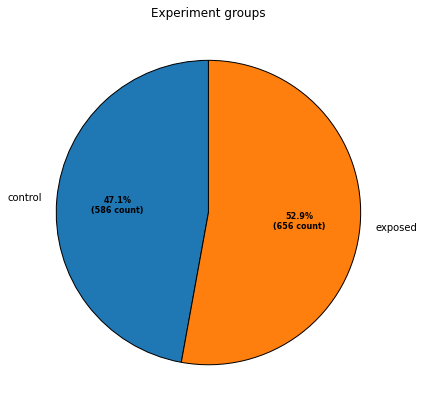

In [8]:
viz.plot_pie(aggr_df, ["experiment", "count"], "Experiment groups")

**Observation**
- experiment groups are almost equal in proportion
- the exposed group is slightly larger in number

In [9]:
# displaying top 10 devices used by users.

temp_df = sumar.find_agg(clean_df, ["device_make"], ["auction_id"], ["count"],["user_count"])
sumar.show_N_per_col(temp_df, "device_make", ["user_count"], 10)


Top 10 customers based on user_count

            device_make  user_count
13   Generic Smartphone         719
68     Samsung SM-G960F          45
66     Samsung SM-G950F          35
72     Samsung SM-G973F          22
43     Samsung SM-A202F          18
114              iPhone          18
64     Samsung SM-G930F          16
73     Samsung SM-G975F          15
47    Samsung SM-A405FN          14
42    Samsung SM-A105FN          13


**Observation**
- following generic device types, samsung models are the most dominant device type

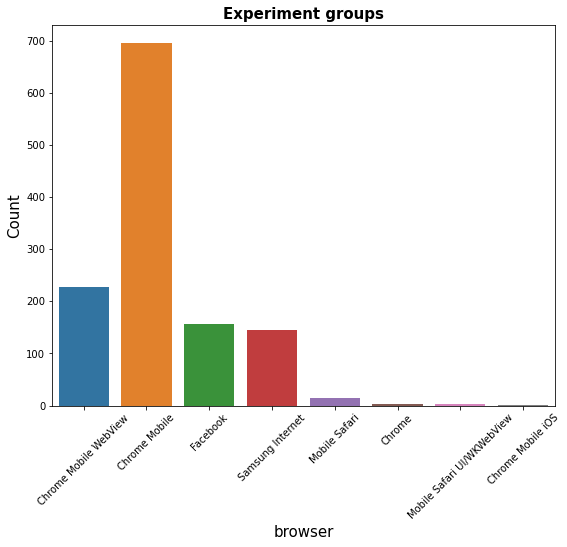

In [13]:
viz.plot_bar(clean_df,"browser", "None", "Experiment groups")

**Observation**
- Chrome browser is the most used type of browser.

## Bivariate Analysis

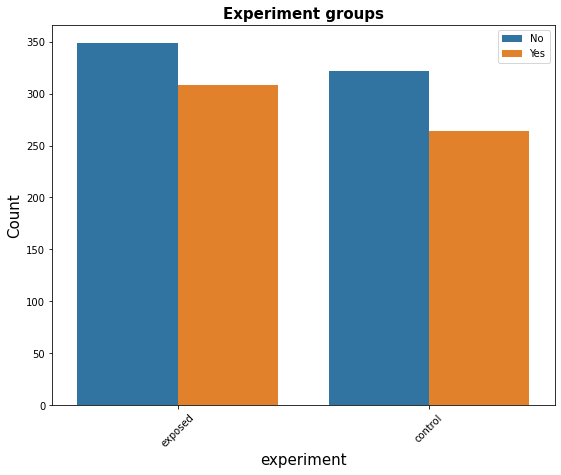

In [15]:
viz.plot_bar(clean_df,"experiment", "yes", "Experiment groups")